### Quadrotor Attitude Dynamics

**(i) Why is this system important?**  
Quadrotors are widely used in engineering applications (e.g. surveillance, delivery). Their stability and maneuverability depend on understanding their attitude dynamics—how they rotate in space. This is critical for control design and robust performance.

**(ii) Key questions to explore:**  
- When is the quadrotor’s attitude stable?  
- How do control torques affect angular acceleration?  
- How sensitive is the system to moment of inertia changes?  
- How does it respond to disturbances (e.g. wind)?

**(iii) Mathematical model:**  
Let angular velocity in the body frame be $\omega = [\omega_x, \omega_y, \omega_z]^T$. The rotational dynamics are:

$$
\begin{aligned}
\dot{\omega}_x &= \frac{1}{J_x} \left( \tau_x + (J_y - J_z)\omega_y \omega_z \right) \\
\dot{\omega}_y &= \frac{1}{J_y} \left( \tau_y + (J_z - J_x)\omega_z \omega_x \right) \\
\dot{\omega}_z &= \frac{1}{J_z} \left( \tau_z + (J_x - J_y)\omega_x \omega_y \right)
\end{aligned}
$$

**Parameters:**  
- $J_x, J_y, J_z$: moments of inertia, e.g. $[0.002, 0.002, 0.004]$ kg·m²  
- $\tau_x, \tau_y, \tau_z$: control torques, range $[-0.1, 0.1]$ N·m  
- $\omega_x, \omega_y, \omega_z$: angular rates, range $[-20, 20]$ rad/s


### Numerical Method: Explicit Runge-Kutta (RK4)

**(i) Why RK4?**  
RK4 balances **accuracy**, **stability**, and **computational cost**. It's well-suited for simulating the quadrotor's nonlinear ODEs without requiring Jacobians or solving implicit equations. It handles moderate stiffness and gives good results with reasonably sized time steps.

**(ii) RK4 Derivation:**  
Given $\dot{\omega} = f(\omega, t)$, RK4 advances from $t_k$ to $t_{k+1} = t_k + h$ via:

$$
\begin{aligned}
k_1 &= f(\omega_k, t_k) \\
k_2 &= f(\omega_k + \tfrac{h}{2}k_1, t_k + \tfrac{h}{2}) \\
k_3 &= f(\omega_k + \tfrac{h}{2}k_2, t_k + \tfrac{h}{2}) \\
k_4 &= f(\omega_k + hk_3, t_k + h) \\
\omega_{k+1} &= \omega_k + \tfrac{h}{6}(k_1 + 2k_2 + 2k_3 + k_4)
\end{aligned}
$$

- **Local error**: $O(h^5)$  
- **Global error**: $O(h^4)$  
- **Stability**: Good for smooth dynamics, time step size $h$ must be chosen conservatively for highly nonlinear or stiff regions.

**(iii) Algorithm Summary:**  
1. Evaluate 4 slopes ($k_1$ to $k_4$) at current state and intermediate steps.  
2. Take weighted average of slopes.  
3. Update state: $\omega_{k+1} = \omega_k +$ weighted sum.  

### RK4 Validation on Quadrotor Dynamics

**(i) Error Convergence Study:**  
To verify our RK4 implementation is correct, we simulate the quadrotor rotational dynamics with constant torque and compare against a reference solution computed using a very small time step. For a properly implemented 4th-order method, the error should scale as $O(h^4)$.

**(ii) Choosing an Accurate Time Step:**  
From the convergence plot, we choose the largest time step that still provides acceptable error (e.g., < 1e-3) for efficient simulation of attitude dynamics. This helps balance **accuracy** and **cost** when studying stability, control, and disturbance rejection in quadrotors.

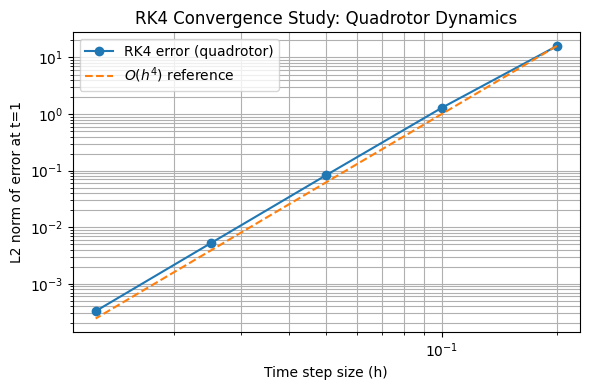

Recommended max time step for error < 1e-3: h = 0.0125


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Quadrotor dynamics with constant torques
def quad_dynamics(omega, t, J=np.array([0.002, 0.002, 0.004]), tau=np.array([0.1, -0.1, 0.05])):
    Jx, Jy, Jz = J
    wx, wy, wz = omega
    domega = np.array([
        (1/Jx)*(tau[0] + (Jy - Jz)*wy*wz),
        (1/Jy)*(tau[1] + (Jz - Jx)*wz*wx),
        (1/Jz)*(tau[2] + (Jx - Jy)*wx*wy)
    ])
    return domega

# RK4 integrator
def rk4_step(f, y, t, h):
    k1 = f(y, t)
    k2 = f(y + 0.5*h*k1, t + 0.5*h)
    k3 = f(y + 0.5*h*k2, t + 0.5*h)
    k4 = f(y + h*k3, t + h)
    return y + (h/6)*(k1 + 2*k2 + 2*k3 + k4)

# Simulate from t=0 to t_end using RK4
def simulate(f, y0, t_end, h):
    t = 0.0
    y = y0.copy()
    while t + h <= t_end + 1e-10:
        y = rk4_step(f, y, t, h)
        t += h
    return y

# Initial condition
omega0 = np.array([1.0, -2.0, 0.5])
t_end = 1.0
dt_values = [0.2, 0.1, 0.05, 0.025, 0.0125]
errors = []

# Reference solution using small time step
ref_solution = simulate(lambda w, t: quad_dynamics(w, t), omega0, t_end, 1e-5)

# Convergence study
for h in dt_values:
    approx = simulate(lambda w, t: quad_dynamics(w, t), omega0, t_end, h)
    error = np.linalg.norm(approx - ref_solution)
    errors.append(error)

# Plotting
plt.figure(figsize=(6,4))
plt.loglog(dt_values, errors, '-o', label='RK4 error (quadrotor)')
plt.loglog(dt_values, [errors[0]*(h/dt_values[0])**4 for h in dt_values], '--', label='$O(h^4)$ reference')
plt.xlabel('Time step size (h)')
plt.ylabel('L2 norm of error at t=1')
plt.title('RK4 Convergence Study: Quadrotor Dynamics')
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()

# Recommend time step
for h, e in zip(dt_values, errors):
    if e < 1e-3:
        print(f"Recommended max time step for error < 1e-3: h = {h}")
        break

## Simulation Results

The following simulations directly address the key questions posed in Part I using the nonlinear quadrotor attitude dynamics model. Each subsection explores a specific property of the system (e.g. stability or control authority) with companion plots and brief analysis.

All simulations use the RK4 integrator implemented earlier, with $J = [0.002, 0.002, 0.004]$ kg·m² and initial condition $\omega_0 = [1.0, -2.0, 0.5]$ unless otherwise noted.

### 1. Stability: Zero Torque

This simulation checks whether the angular velocity remains constant (or evolves smoothly) in the absence of torque. For a rigid body with no external torques, Euler's equations should preserve angular momentum, but nonlinear coupling may still lead to evolution in angular velocity.

If the body is symmetric (e.g. $J_x = J_y$), the motion is more likely to be stable.

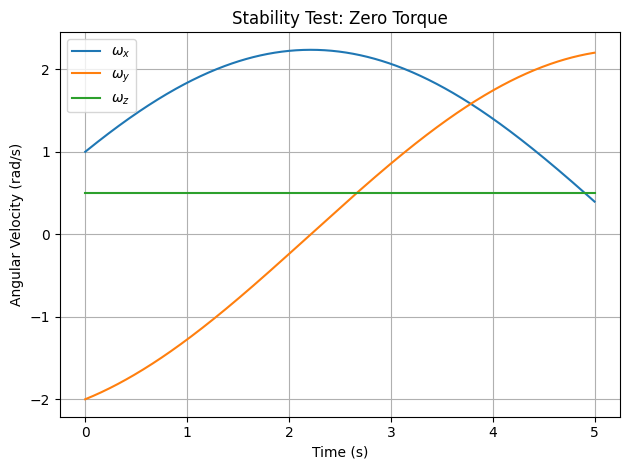

In [ ]:
def simulate_time_history(f, y0, t_end, h):
    t_values = [0.0]
    y_values = [y0.copy()]
    t = 0.0
    y = y0.copy()
    while t + h <= t_end + 1e-10:
        y = rk4_step(f, y, t, h)
        y_values.append(y)
        t += h
        t_values.append(t)
    return np.array(t_values), np.array(y_values)

# Stability test with zero torque
J = np.array([0.002, 0.002, 0.004])
tau = np.array([0.0, 0.0, 0.0])
omega0 = np.array([1.0, -2.0, 0.5])
f_stability = lambda w, t: quad_dynamics(w, t, J=J, tau=tau)

t_vals, omega_vals = simulate_time_history(f_stability, omega0, t_end=5.0, h=0.01)

plt.figure()
for i, label in enumerate(['$\omega_x$', '$\omega_y$', '$\omega_z$']):
    plt.plot(t_vals, omega_vals[:, i], label=label)
plt.title('Stability Test: Zero Torque')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 2. Control Authority: Varying Torque Magnitude

We compare the angular acceleration and rotation response of the quadrotor under different torque magnitudes. This illustrates how quickly the system can rotate under higher or lower control authority.

We simulate three cases:
- Low torque: ±0.01 N·m
- Medium torque: ±0.05 N·m
- High torque: ±0.1 N·m

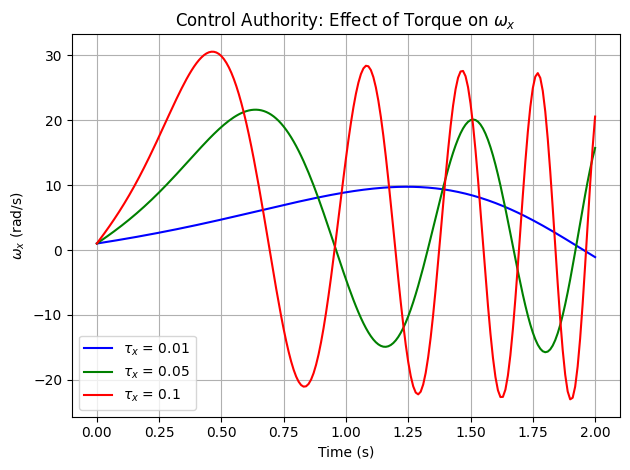

In [ ]:
torque_levels = [0.01, 0.05, 0.1]
colors = ['blue', 'green', 'red']
t_end = 2.0

plt.figure()
for T, color in zip(torque_levels, colors):
    tau = np.array([T, -T, T/2])
    f = lambda w, t: quad_dynamics(w, t, J=J, tau=tau)
    t_vals, omega_vals = simulate_time_history(f, omega0, t_end=t_end, h=0.01)
    plt.plot(t_vals, omega_vals[:, 0], label=f'$\\tau_x$ = {T}', color=color)

plt.title('Control Authority: Effect of Torque on $\\omega_x$')
plt.xlabel('Time (s)')
plt.ylabel('$\\omega_x$ (rad/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 3. Parameter Sensitivity: Varying $J_x$

We examine how the response of $\omega_x$ changes as we vary $J_x$ (moment of inertia about x-axis). A smaller inertia leads to faster angular acceleration (for the same torque), while a larger $J_x$ slows down the response.

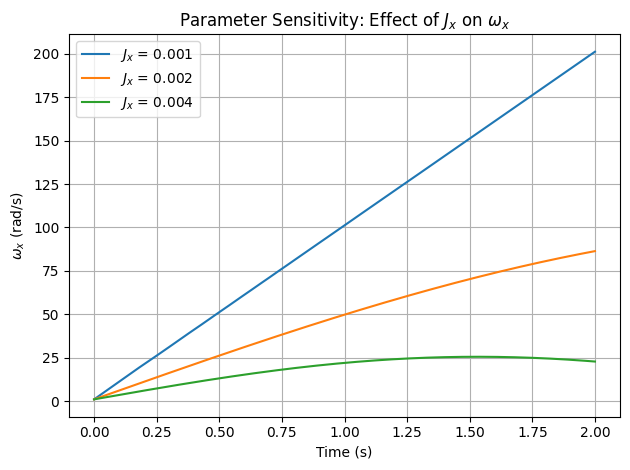

In [ ]:
J_values = [0.001, 0.002, 0.004]
tau = np.array([0.1, 0.0, 0.0])  # Torque only on x-axis

plt.figure()
for Jx in J_values:
    J_mod = np.array([Jx, 0.002, 0.004])
    f = lambda w, t: quad_dynamics(w, t, J=J_mod, tau=tau)
    t_vals, omega_vals = simulate_time_history(f, omega0, t_end=2.0, h=0.01)
    plt.plot(t_vals, omega_vals[:, 0], label=f'$J_x$ = {Jx:.3f}')

plt.title('Parameter Sensitivity: Effect of $J_x$ on $\\omega_x$')
plt.xlabel('Time (s)')
plt.ylabel('$\\omega_x$ (rad/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 4. Disturbance Rejection: Impulse Torque (Wind Gust)

We apply a sudden torque disturbance on the y-axis between $t = 0.5$ and $t = 0.6$ seconds to simulate a wind gust. This tests whether the system passively stabilizes or diverges under an external input.

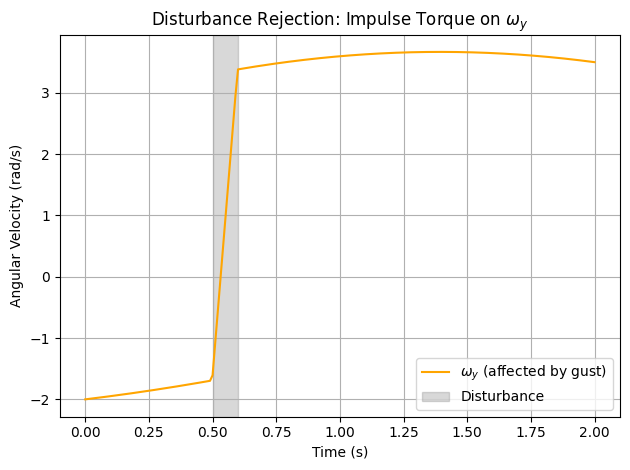

In [ ]:
def gust_disturbance(t):
    if 0.5 <= t <= 0.6:
        return np.array([0.0, 0.1, 0.0])
    else:
        return np.array([0.0, 0.0, 0.0])

def f_with_gust(w, t):
    return quad_dynamics(w, t, J=J, tau=gust_disturbance(t))

t_vals, omega_vals = simulate_time_history(f_with_gust, omega0, t_end=2.0, h=0.01)

plt.figure()
plt.plot(t_vals, omega_vals[:, 1], label='$\\omega_y$ (affected by gust)', color='orange')
plt.axvspan(0.5, 0.6, color='gray', alpha=0.3, label='Disturbance')
plt.title('Disturbance Rejection: Impulse Torque on $\\omega_y$')
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary of Results

- **Stability**: In the absence of torque, the system preserves angular momentum but may exhibit nonlinear precession (especially if $J_x \neq J_z$).
- **Control Authority**: Higher torques result in faster angular acceleration. This must be balanced in controller design.
- **Parameter Sensitivity**: The moment of inertia significantly affects response speed. Tuning or estimating $J$ accurately is crucial.
- **Disturbance Rejection**: The system does not self-stabilize without feedback control. A transient gust results in permanent deflection of $\omega_y$.

These insights will inform any future controller design and help set time step limits for accurate simulation.